In [3]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib as plt
from pdb import set_trace
from scipy.signal import argrelextrema

%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.get_backend()



'nbAgg'

# Project - Housing prices

**Hypothesis**: University towns have their mean housing prices less effected by recessions.  (`price_ratio=quarter_before_recession-recession_bottom/quarter_before_recession`)

The following data files will be used:
* From the [Zillow research data site](http://www.zillow.com/research/data/) there is housing data for the United States. In particular the datafile for [all homes at a city level](http://files.zillowstatic.com/research/public/City/City_Zhvi_AllHomes.csv), ```City_Zhvi_AllHomes.csv```, has median home sale prices at a fine grained level.
* From the Wikipedia page on college towns is a list of [university towns in the United States](https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States) which has been copy and pasted into the file ```university_towns.txt```.
* From Bureau of Economic Analysis, US Department of Commerce, the [GDP over time](http://www.bea.gov/national/index.htm#gdp) of the United States in current dollars, in quarterly intervals, in the file ```gdplev.xls```.

In [4]:
# Dictionary to map state names to two letter acronyms
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}

In [8]:
def get_list_of_university_towns():
    '''Returns a DataFrame of towns and the states they are in from the 
    university_towns.txt list. The format is:
    DataFrame( [ ["Michigan", "Ann Arbor"], ["Michigan", "Yipsilanti"] ], 
    columns=["State", "RegionName"]  )
    
    The following cleaning is done:
    
    1. For "State", removed characters from "[" to the end.
    2. For "RegionName", when applicable, removed every character from " (" to the end.'''
    
    
    Un_sity= pd.read_table('university_towns.txt', header=None)
    tmp = ''
    deldubl= False
    Un_sity[1] = [0 for i in range(len(Un_sity))]
    for i in range(len(Un_sity)):
        if '[edit]' in Un_sity.iloc[i,0]:
             tmp= Un_sity.iloc[i,0].split('[')[0]        
        Un_sity.iloc[i,1] = tmp
        if '(' in Un_sity.iloc[i,0]:
            Un_sity.iloc[i,0] = Un_sity.iloc[i,0].split('(')[0]
    Un_sity.columns = ["RegionName","State"]
    Un_sity['RegionName'] = Un_sity['RegionName'].apply(lambda x: x.strip(' '))   
    Un_sity = (Un_sity[Un_sity.RegionName.str.contains('\[edit\]') == False]
               .reset_index(drop=True))
    col = Un_sity.columns.tolist()
    col = col[-1:] + col[:-1]
    Un_sity = Un_sity[col]
    return Un_sity

get_list_of_university_towns()

,State,RegionName
0,Alabama,Auburn
1,Alabama,Florence
2,Alabama,Jacksonville
3,Alabama,Livingston
4,Alabama,Montevallo
5,Alabama,Troy
6,Alabama,Tuscaloosa
7,Alabama,Tuskegee
8,Alaska,Fairbanks
9,Arizona,Flagstaff


In [10]:
gdplev = pd.read_excel('gdplev.xls',skiprows=5)

gdplev_year = gdplev.loc[:,'Unnamed: 0':'GDP in billions of chained 2009 dollars']
gdplev_year.columns = ['Date','GDP in billions of current dollars','GDP in billions of chained 2009 dollars']
gdplev_year.dropna(axis=0, how='all',inplace=True)   
gdplev_year['Date'] = (gdplev_year['Date'].astype(str).apply(lambda x: pd.to_datetime(x, format='%Y.0'))
                       .apply(lambda x: x.year))


gdplev_quart = gdplev.loc[:,'Unnamed: 4':'GDP in billions of chained 2009 dollars.1']
gdplev_quart.dropna(axis=0, how='all',inplace=True)
gdplev_quart.columns = ['Date','GDP in billions of current dollars','GDP in billions of chained 2009 dollars']

gdplev_quart = gdplev_quart.set_index('Date')
gdplev_quart.drop(gdplev_quart.index[:-66], inplace=True)


qw_ind = list(gdplev_quart.index)
gdplev_quart_ress = gdplev_quart.iloc[-40:-15]
#gdplev_quart_ress.plot(y='GDP in billions of chained 2009 dollars', kind='line')

In [11]:
def get_recession_start():
    '''Returns the year and quarter of the recession start time as a 
    string value in a format such as 2005q3'''    
    x = argrelextrema(gdplev_quart['GDP in billions of chained 2009 dollars'].values,np.less)
    return gdplev_quart.index.values[x[0][2]]

get_recession_start()

'2008q1'

In [12]:
def get_recession_end():
    '''Returns the year and quarter of the recession end time as a 
    string value in a format such as 2005q3'''
    x = argrelextrema(gdplev_quart['GDP in billions of chained 2009 dollars'].values,np.greater)
    return gdplev_quart.index.values[x[0][4]]
get_recession_end()

'2010q4'

In [13]:
def get_recession_bottom():
    '''Returns the year and quarter of the recession bottom time as a 
    string value in a format such as 2005q3'''
    x = argrelextrema(gdplev_quart['GDP in billions of chained 2009 dollars'].values,np.less)
    return gdplev_quart.index.values[x[0][3]]
get_recession_bottom()

'2009q2'

In [20]:
#test data
def new_col_names():
    #generating the new coloumns names 
    years = list(range(2000,2017))
    quars = ['q1','q2','q3','q4']
    quar_years = []
    for i in years:
        for x in quars:
            quar_years.append((str(i)+x))
    return quar_years[:67]
def convert_housing_data_to_quarters():
    '''Converts the housing data to quarters and returns it as mean 
    values in a dataframe. This dataframe should be a dataframe with
    columns for 2000q1 through 2016q3, and should have a multi-index
    in the shape of ["State","RegionName"].
    
    Note: Quarters are defined in the assignment description, they are
    not arbitrary three month periods.
    
    The resulting dataframe should have 67 columns, and 10,730 rows.
    '''
    data = pd.read_csv('City_Zhvi_AllHomes.csv')
    data.drop(['Metro','CountyName','RegionID','SizeRank'],axis=1,inplace=True)
    data['State'] = data['State'].map(states)
    data.set_index(['State','RegionName'],inplace=True)
    col = list(data.columns)
    col = col[0:45]
    data.drop(col,axis=1,inplace=True)

    #qs is the quarters of the year
    qs = [list(data.columns)[x:x+3] for x in range(0, len(list(data.columns)), 3)]
    
    # new columns
    column_names = new_col_names()
    for col,q in zip(column_names,qs):
        data[col] = data[q].mean(axis=1)
        
    data = data[column_names]
    return data

convert_housing_data_to_quarters()

,,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3
State,RegionName,,,,,,
New York,New York,5.408000e+05,5.572000e+05,5.728333e+05,5.828667e+05,5.916333e+05,587200.0
California,Los Angeles,5.381667e+05,5.472667e+05,5.577333e+05,5.660333e+05,5.774667e+05,584050.0
Illinois,Chicago,2.060333e+05,2.083000e+05,2.079000e+05,2.060667e+05,2.082000e+05,212000.0
Pennsylvania,Philadelphia,1.179667e+05,1.212333e+05,1.222000e+05,1.234333e+05,1.269333e+05,128700.0
Arizona,Phoenix,1.741667e+05,1.790667e+05,1.838333e+05,1.879000e+05,1.914333e+05,195200.0
Nevada,Las Vegas,1.816000e+05,1.867667e+05,1.906333e+05,1.946000e+05,1.972000e+05,199950.0
California,San Diego,5.120667e+05,5.197667e+05,5.254667e+05,5.293333e+05,5.362333e+05,539750.0
Texas,Dallas,1.211333e+05,1.285667e+05,1.346000e+05,1.405000e+05,1.446000e+05,149300.0
California,San Jose,7.567333e+05,7.764000e+05,7.891333e+05,8.036000e+05,8.189333e+05,822200.0


In [21]:
def convert_housing_data_to_quarters1():
    '''Converts the housing data to quarters and returns it as mean 
    values in a dataframe.
    '''
    City_Zhvi= pd.read_csv('City_Zhvi_AllHomes.csv')
    City_Zhvi['State'] = City_Zhvi['State'].map(states)
    City_Zhvi = City_Zhvi.set_index(['State','RegionName']).iloc[:,-200:]
    qw_ind.append('2016q3')
    City_Zhvi_qw = pd.DataFrame(index=City_Zhvi.index,columns=qw_ind)

    City_t = City_Zhvi.T
    City_t.index = City_t.index.map(lambda x: x.split('-')[0])
    i=0
    for group, frame in City_t.groupby(level=0):
        if group != '2016':
            df1, df2, df3, df4 = np.array_split(frame, 4)
            City_Zhvi_qw[qw_ind[i]] =df1.mean(axis=0)
            City_Zhvi_qw[qw_ind[i+1]] =df2.mean(axis=0)
            City_Zhvi_qw[qw_ind[i+2]] =df3.mean(axis=0)
            City_Zhvi_qw[qw_ind[i+3]] =df4.mean(axis=0)
            i+=4

        else:
            df1, df2 = np.array_split(frame[:-2], 2)
            df3 = frame.iloc[-2:]

            City_Zhvi_qw[qw_ind[i]] =df1.mean(axis=0)
            City_Zhvi_qw[qw_ind[i+1]] =df2.mean(axis=0)
            City_Zhvi_qw[qw_ind[i+2]] =df3.mean(axis=0)

    return City_Zhvi_qw

#convert_housing_data_to_quarters1()

In [22]:
def cut_to_cohort(begin, end):
    def is_uni_town(row):
        #check if the town is a university towns or not.
        if row['RegionName'] in uni_town:
            return 1
        else:
            return 0
    

    price_ratio =  (lambda row : (row[oneq_befor] - row[get_recession_bottom()])/row[oneq_befor])
    uni_town = get_list_of_university_towns()['RegionName']
    uni_town = set(uni_town)
    
    df = (convert_housing_data_to_quarters()
          .copy()
          .loc[:,begin:end]
          .reset_index())
    oneq_befor = '2007q4'
    df['is_uni'] = df.apply(is_uni_town,axis=1)
    df['up&down'] = df.apply(price_ratio,axis=1)    
    not_uni = df[df['is_uni']==0].loc[:,'up&down'].dropna()
    is_uni  = df[df['is_uni']==1].loc[:,'up&down'].dropna()
    
    return df, not_uni, is_uni


In [23]:
def get_avr_from_tabl():
    begin = '2000q1'
    end = '2010q2'
    df = cut_to_cohort(begin,end)[0]
    is_un = df[df['is_uni']==1].mean()
    is_un['type'] = 'University sity'
    not_un = df[df['is_uni']==0].mean()
    not_un['type'] = 'NOT University sity'
    gdp = gdplev_quart.loc[:end, 'GDP in billions of chained 2009 dollars']
    gdp['type'] = 'GDP'
    col = ['type'] + list(df.columns[2:-3])
    
    avrg_for_cohort = (pd.DataFrame([is_un,not_un,gdp], columns = col)
                       .set_index('type'))
    
    return avrg_for_cohort

In [24]:
def get_diff_from_tab1(begin,end):
    df = (get_avr_from_tabl()
          .loc[:,begin:end])
    return df.iloc[1] - df.iloc[0]  

In [27]:
get_avr_from_tabl().loc[:,'2008q3':"2010q1"]

,2008q3,2008q4,2009q1,2009q2,2009q3,2009q4,2010q1
type,,,,,,,
University sity,204965.392520,201176.120016,198745.582822,195525.336597,192207.414141,190618.258767,189493.623361
NOT University sity,239272.003013,233714.631548,230301.692866,225910.234464,220984.097050,218951.894839,217091.016083
GDP,14891.600000,14577.000000,14375.000000,14355.600000,14402.500000,14541.900000,14604.800000


In [23]:
get_diff_from_tab1('2005q1','2012q4')

2005q1    34484.892194
2005q2    36507.833401
2005q3    38013.963106
2005q4    39280.525888
2006q1    40208.411738
2006q2    40966.360616
2006q3    41283.580468
2006q4    41320.803414
2007q1    40512.073244
2007q2    39939.215727
2007q3    39198.475281
2007q4    38408.669024
2008q1    37140.844129
2008q2    35844.247949
2008q3    34306.610493
2008q4    32538.511532
2009q1    31556.110044
2009q2    30384.897866
2009q3    28776.682908
2009q4    28333.636073
2010q1    27597.392722
dtype: float64

<IPython.core.display.Javascript object>


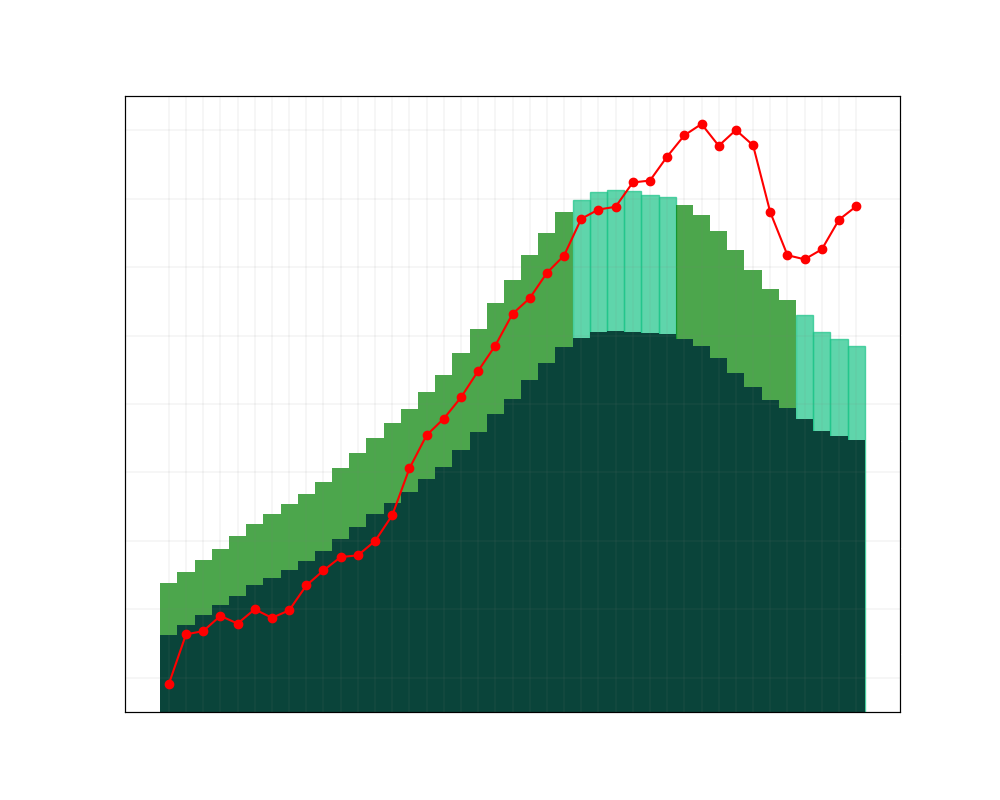

In [39]:
def vis_convert_housing_data_to_quarters_bar():
    ###get data
    df = get_avr_from_tabl()
    ####set plot
    xvals = np.arange(len(df.columns))
    bar_width = 1
    n_groups = 6
    opacity = 0.7
    ###plot
    fig, ax = plt.subplots(figsize=(10,8))
    
    rect2 = ax.bar(xvals,
                    df.iloc[1,:], 
                    bar_width,
                    alpha=opacity,
                    color='g', 
                    label='Other districts real estate average price')
    
    rect1 = ax.bar(xvals, 
                    df.iloc[0,:],
                    bar_width,
                    #alpha=opacity,
                    color='#0a443a', 
                    label='University district real estate average price')
    #hightline first bars area
    highcolor = '#1bc488'
    for x in range(24,30):
        rect2[x].set_color(highcolor)
    #hightline second bars area
    for x in xvals[-4:]:
        rect2[x].set_color(highcolor)
    
    ax2 = ax.twinx()
    line2 = ax2.plot(xvals,
                     df.iloc[2,:],
                     '-o',
                    color ='r',
                    label='GDP')
    #do rotation
    for item in ax.xaxis.get_ticklabels():
        item.set_rotation(70)
    
    ###lable axces
    plt.xlabel('Date')
    #plt.ylabel('Avarage price')
    ax.set_ylabel('Avarage price')
    ax2.set_ylabel('GDP')
    plt.title('Real Estate average price')
    #plt.legend(['University district real estate average price',
     #          'Other districts real estate average price',
      #         "GDP"])

    ax.set_ylim([110000,290000])
    ax.set_xticks(xvals)
    ax.set_xticklabels(list(df.columns))
    ax.yaxis.label.set_color('w')
    ax2.yaxis.label.set_color('w')
    ax.xaxis.label.set_color('w')
    ax.title.set_color('w')
    ax2.title.set_color('w')
    ax.tick_params(colors='w')
    ax2.tick_params(colors='w')
    ax.grid(color='grey', linestyle='-', linewidth=.1)
    ###
    plt.show()
    
vis_convert_housing_data_to_quarters_bar()

<IPython.core.display.Javascript object>


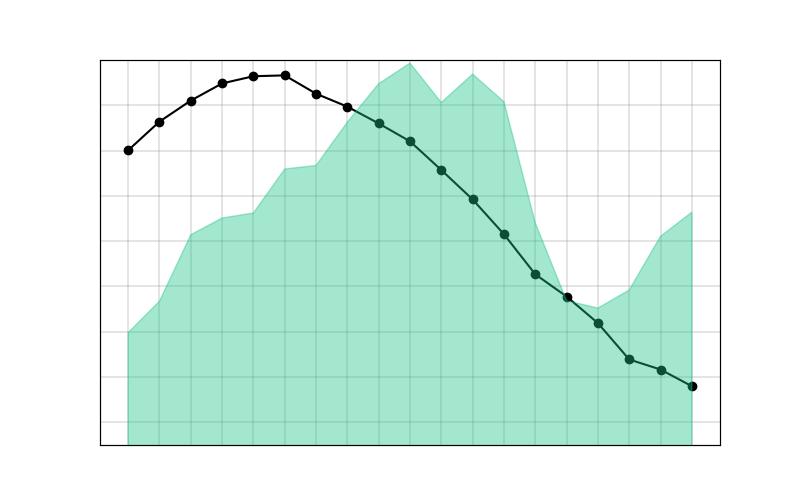

In [38]:
def plot_the_diff():
    df = get_avr_from_tabl()
    df = df.loc[:,'2005q3':'2010q2']
    xvals = np.arange(len(df.columns))
    serries = get_diff_from_tab1('2005q3','2010q2')
    fig, ax = plt.subplots(figsize=(8,5))
    
    
    ax2 = ax.twinx()
    area = ax2.stackplot(xvals,
                         df.iloc[2,:],
                        alpha =0.4,
                        color="#1bc488")
    line1 =ax.plot(serries,
                   '-o',
                   alpha =1,
                   color='black')
    ###lable axis
    plt.title('Univ/Not Univ. Spread')
    ax.set_xlabel('Date')
    ax.set_ylabel('Univ/Not Univ. Spread')
    ax2.set_ylabel('GDP')
    #axis set
    ax.set_ylim([25000,42000])
    ax2.set_ylim([14000,15000])
    ax.yaxis.label.set_color('w')
    ax.title.set_color('w')
    ax2.yaxis.label.set_color('w')
    ax.xaxis.label.set_color('w')
    ax.title.set_color('w')
    ax.tick_params(colors='w')
    ax2.tick_params(colors='w')
    ax.grid(color='grey', linestyle='-', linewidth=0.3)
    plt.legend()
    for item in ax.xaxis.get_ticklabels():
        item.set_rotation(45)
    #
    ax2.title.set_color('w')
    plt.show()
plot_the_diff()

In [26]:
def run_ttest():
    '''First creates new data showing the decline or growth of housing prices
    between the recession start and the recession bottom. Then runs a ttest
    comparing the university town values to the non-university towns values, 
    return whether the alternative hypothesis (that the two groups are the same)
    is true or not as well as the p-value of the confidence. 
    
    Return the tuple (different, p, better) where different=True if the t-test is
    True at a p<0.01 (we reject the null hypothesis), or different=False if 
    otherwise (we cannot reject the null hypothesis). The variable p should
    be equal to the exact p value returned from scipy.stats.ttest_ind(). The
    value for better should be either "university town" or "non-university town"
    depending on which has a lower mean price ratio (which is equivilent to a
    reduced market loss).'''
    def is_test_true():
        if p_val < 0.01:
            return True
        else:
            return False
    def is_better():
        if not_uni.mean() < is_uni.mean():
            return 'non-university town'
        else:
            return 'university town'
    df, not_uni, is_uni = cut_to_cohort('2006q4','2009q2')
    p_val = list(ttest_ind(not_uni,is_uni))[1]
    return (is_test_true(),p_val,is_better())

run_ttest()

(True, 1.7900059546810142e-05, 'university town')